In [1]:
# connecting drove to google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download necessary libraries

In [2]:
!pip install tensorflow
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 19.5 MB/s eta 0:00:00


## Import libraries used in this project

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, random_split
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.nn import SyncBatchNorm
from torchvision.models import resnet50
from torchvision.io import read_image
from torchvision.transforms import ToPILImage
from PIL import Image
from accelerate import Accelerator
from accelerate import notebook_launcher

import warnings
warnings.filterwarnings("ignore")

## Configuration parameters

In [4]:
Config = {
    'TARGET_SHAPE': (200, 200),
    'NUM_EPOCHS': 10,
    'MARGIN': 0.5,
    'LR': 1e-4
}


## Set seed for reproducibility

In [5]:
def set_seed(seed_value=123):
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed_value)

set_seed()

## Utility function to get image paths

In [6]:
def get_image_paths(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

## Define paths for left and right images

In [7]:
left_dir_path = "/content/drive/MyDrive/deep learning five/train/left"
right_dir_path = "/content/drive/MyDrive/deep learning five/train/right"

left_images_path = get_image_paths(left_dir_path)
right_images_path = get_image_paths(right_dir_path)

print(f"Number of left images: {len(left_images_path)}\n")
print(f"Number of right images: {len(right_images_path)}\n")

Number of left images: 2027

Number of right images: 2000



## Utility function to check if images have the same shape

In [8]:
def check_image_shapes(images_paths):
    shape = cv2.imread(images_paths[0]).shape
    for image_path in images_paths:
        image_shape = cv2.imread(image_path).shape
        if image_shape != shape:
            return "Different image shape"
    return "Same image shape " + str(shape)

check_image_shapes(left_images_path)
check_image_shapes(right_images_path)

'Same image shape (245, 200, 3)'

## Sort the list based on the image file names

In [9]:
sorted_left_images = sorted(left_images_path, key=lambda x: x.split('/')[-1])
sorted_right_images = sorted(right_images_path, key=lambda x: x.split('/')[-1])

## Data preprocessing function for a single image tensor

In [10]:
def preprocess_image(image_tensor):
    transform = transforms.Compose([
        transforms.Resize(Config['TARGET_SHAPE'], antialias=True),
    ])
    return transform(image_tensor)

## Data preprocessing function for triplets

In [11]:
def preprocess_triplets(anchor, positive, negative):
    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

## Dataset class for the Totally-Looks-Like Challenge

In [12]:
class TLLDataset(Dataset):
    def __init__(self, anchor_image_paths, positive_image_paths):
        anchor_images = [read_image(path) for path in anchor_image_paths]
        positive_images = [read_image(path) for path in positive_image_paths]

        # Shuffle anchor and positive images to get negative images
        negative_images = anchor_images + positive_images
        random.shuffle(negative_images)

        # Separate anchor and positive images from negative images
        anchor_images = negative_images[:len(anchor_images)]
        positive_images = negative_images[len(anchor_images):]

        self.anchor_images = torch.stack(anchor_images)
        self.positive_images = torch.stack(positive_images)
        self.negative_images = torch.stack(negative_images)

    def __len__(self):
        return len(self.anchor_images)

    def __getitem__(self, idx):
        anchor = self.anchor_images[idx]
        positive = self.positive_images[idx]
        negative = self.negative_images[idx]

        anchor, positive, negative = preprocess_triplets(anchor, positive, negative)

        return anchor, positive, negative

## Create an instance of TLLDataset

In [13]:
tll_dataset = TLLDataset(sorted_left_images, sorted_right_images)

## Determine the indices for training, validation, and testing

In [14]:
image_count = len(tll_dataset)
indices = list(range(image_count))


## Define split points

In [15]:
train_split = round(image_count * 0.8)
val_split = train_split + round(image_count * 0.1)

train_indices = indices[:train_split]
val_indices = indices[train_split:val_split]
test_indices = indices[val_split:]

## Create SubsetRandomSamplers

In [16]:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

## Create DataLoaders for training, validation, and testing

In [17]:
train_loader = DataLoader(tll_dataset, batch_size=16, sampler=train_sampler, num_workers=8, drop_last=True)
val_loader = DataLoader(tll_dataset, batch_size=16, sampler=val_sampler, num_workers=8, drop_last=True)
test_loader = DataLoader(tll_dataset, batch_size=16, sampler=test_sampler, num_workers=8, drop_last=True)

## Embedding network class

In [18]:
class ImageEmbeddingNet(nn.Module):
    def __init__(self):
        super(ImageEmbeddingNet, self).__init__()

        # Load a pre-trained ResNet50 model
        resnet = resnet50()

        # Freeze all layers except the last Convolution block
        for name, param in resnet.named_parameters():
            if "layer4" not in name:
                param.requires_grad = False

        # Define the embedding network by adding a few dense layers
        self.features = nn.Sequential(*list(resnet.children())[:-1])  # Exclude the last FC layer
        self.flatten = nn.Flatten()
        self.dense1 = nn.Sequential(nn.Linear(2048, 512), nn.ReLU(), SyncBatchNorm(512))
        self.dense2 = nn.Sequential(nn.Linear(512, 256), nn.ReLU(), SyncBatchNorm(256))
        self.output = nn.Linear(256, 256)

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.output(x)
        return x

## Distance layer class

In [19]:
class DistanceLayer(nn.Module):
    def __init__(self):
        super(DistanceLayer, self).__init__()

    def forward(self, anchor, positive, negative):
        ap_distance = F.pairwise_distance(anchor, positive, 2)
        an_distance = F.pairwise_distance(anchor, negative, 2)
        return ap_distance, an_distance

## Triplet margin loss class

In [20]:
class TripletMarginLoss(nn.Module):
    def __init__(self, margin):
        super(TripletMarginLoss, self).__init__()
        self.margin = margin

    def forward(self, ap_distance, an_distance):
        return F.relu(ap_distance - an_distance + self.margin).mean()

## Siamese network class

In [21]:
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNetwork, self).__init__()
        self.embedding_net = embedding_net
        self.distance_layer = DistanceLayer()

    def forward(self, anchor, positive, negative):
        anchor_embedding = self.embedding_net(anchor)
        positive_embedding = self.embedding_net(positive)
        negative_embedding = self.embedding_net(negative)
        ap_distance, an_distance = self.distance_layer(anchor_embedding, positive_embedding, negative_embedding)
        return ap_distance, an_distance

## Training function

In [22]:
def train_siamese_network(model, optimizer, train_loader, val_loader, num_epochs, margin, device, accelerator):
    criterion = TripletMarginLoss(margin)

    for epoch in range(num_epochs):
        accelerator.print(f"{'='*20} Epoch: {epoch+1} {'='*20}\n")

        # Training
        model.train()
        train_loss = 0.0
        for idx, (anchor, positive, negative) in enumerate(train_loader):
            optimizer.zero_grad()

            anchor = anchor.to(device, dtype=torch.float)
            positive = positive.to(device, dtype=torch.float)
            negative = negative.to(device, dtype=torch.float)
            ap_distance, an_distance = model(anchor, positive, negative)
            loss = criterion(ap_distance, an_distance)

            accelerator.backward(loss)
            optimizer.step()

            train_loss += loss.item()
            if idx % 100 == 0:
                accelerator.print(f"Epoch: {epoch+1}/{num_epochs}, Batch: {idx}, Training Loss: {loss.item():.4f}")

        avg_train_loss = train_loss / len(train_loader)
        accelerator.print(f"\nEpoch: {epoch+1} / {num_epochs}  |  Average Training Loss: {avg_train_loss:.4f}\n")

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for idx, (anchor, positive, negative) in enumerate(val_loader):
                anchor = anchor.to(device, dtype=torch.float)
                positive = positive.to(device, dtype=torch.float)
                negative = negative.to(device, dtype=torch.float)
                ap_distance, an_distance = model(anchor, positive, negative)
                loss = criterion(ap_distance, an_distance)

                val_loss += loss.item()
                if idx % 10 == 0:
                    accelerator.print(f"Epoch: {epoch+1}/{num_epochs}, Batch: {idx}, Validation Loss: {loss.item():.4f}")

        avg_val_loss = val_loss / len(val_loader)
        accelerator.print(f"\nEpoch: {epoch+1} / {num_epochs}  |  Average Validation Loss: {avg_val_loss:.4f}\n")

        # Save the model
        accelerator.wait_for_everyone()
        model = accelerator.unwrap_model(model)
        model_path = f"epoch_{epoch+1}_model.pth"
        accelerator.save(model, model_path)

## Training loop

In [23]:
def run_training_loop(train_loader, val_loader, Config):
    accelerator = Accelerator()
    device = accelerator.device

    embedding_net = ImageEmbeddingNet()
    siamese_model = SiameseNetwork(embedding_net)
    siamese_model = siamese_model.to(device)
    optimizer = torch.optim.Adam(siamese_model.parameters(), lr=Config['LR'])

    siamese_model, optimizer, train_loader, val_loader = accelerator.prepare(
        siamese_model, optimizer, train_loader, val_loader
    )

    # Start training
    train_siamese_network(
        model=siamese_model,
        optimizer=optimizer,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=Config['NUM_EPOCHS'],
        margin=Config['MARGIN'],
        device=device,
        accelerator=accelerator,
    )

args = (train_loader, val_loader, Config)
notebook_launcher(run_training_loop, args, num_processes=2)

Launching training on one GPU.
==================== Epoch: 1 ====================

Epoch: 1/10, Batch: 0, Training Loss: 12.6135
Epoch: 1/10, Batch: 100, Training Loss: 1.5606

Epoch: 1 / 10  |  Average Training Loss: 4.3797

Epoch: 1/10, Batch: 0, Validation Loss: 9.6186
Epoch: 1/10, Batch: 10, Validation Loss: 6.1043

Epoch: 1 / 10  |  Average Validation Loss: 7.8735

==================== Epoch: 2 ====================

Epoch: 2/10, Batch: 0, Training Loss: 1.5228
Epoch: 2/10, Batch: 100, Training Loss: 0.9596

Epoch: 2 / 10  |  Average Training Loss: 1.3182

Epoch: 2/10, Batch: 0, Validation Loss: 5.0532
Epoch: 2/10, Batch: 10, Validation Loss: 2.2710

Epoch: 2 / 10  |  Average Validation Loss: 2.6056

==================== Epoch: 3 ====================

Epoch: 3/10, Batch: 0, Training Loss: 0.9946
Epoch: 3/10, Batch: 100, Training Loss: 0.8447

Epoch: 3 / 10  |  Average Training Loss: 0.9393

Epoch: 3/10, Batch: 0, Validation Loss: 6.8895
Epoch: 3/10, Batch: 10, Validation Loss: 0.75

## Function to compute similarity

In [24]:
def compute_similarity(model, anchor, positive, negative):
    with torch.no_grad():
        anchor_embedding = model(anchor).squeeze(0).view(-1)
        positive_embedding = model(positive).squeeze(0).view(-1)
        negative_embedding = model(negative).squeeze(0).view(-1)

    positive_similarity = F.cosine_similarity(anchor_embedding.unsqueeze(0), positive_embedding.unsqueeze(0))
    negative_similarity = F.cosine_similarity(anchor_embedding.unsqueeze(0), negative_embedding.unsqueeze(0))

    return positive_similarity.item(), negative_similarity.item()

## Inference loop

In [25]:
def run_inference(model, device, anchor, positive, negative, is_pretrained=True):
    # Ensure the input tensors are on the correct device
    anchor = anchor.to(device, dtype=torch.float)
    positive = positive.to(device, dtype=torch.float)
    negative = negative.to(device, dtype=torch.float)

    model = model.to(device)
    model.eval()  # Set the model to evaluation mode

    pos_sim, neg_sim = compute_similarity(model, anchor, positive, negative)

    model_type = "Pretrained Model" if is_pretrained else "Fine-tuned Model"

    print(f"\nFor {model_type}:")
    print("Positive similarity:", pos_sim)
    print("Negative similarity:", neg_sim)

## Define the path to test data

In [26]:
test_data_dir = "/content/drive/MyDrive/deep learning five/test"

## Data transforms

In [27]:
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
])

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## TripletImageFolder for the test dataset

In [29]:
import random
from torchvision.datasets import ImageFolder

class TripletImageFolder(ImageFolder):
    def __getitem__(self, index):
        anchor, anchor_label = super().__getitem__(index)

        # Find a positive sample with the same class as the anchor
        positive_index = random.choice(
            [idx for idx in range(len(self.imgs)) if self.imgs[idx][1] == anchor_label]
        )
        positive, _ = super().__getitem__(positive_index)

        # Find a negative sample with a different class from the anchor
        negative_label = random.choice(
            [label for label in range(len(self.classes)) if label != anchor_label]
        )
        negative_index = random.choice(
            [idx for idx in range(len(self.imgs)) if self.imgs[idx][1] == negative_label]
        )
        negative, _ = super().__getitem__(negative_index)

        return anchor, positive, negative

## Test dataset

In [30]:
test_dataset = TripletImageFolder(root=test_data_dir, transform=transform)

## Test loader

In [31]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=8)
anchor, positive, negative = next(iter(test_loader))

## Visualize triplets

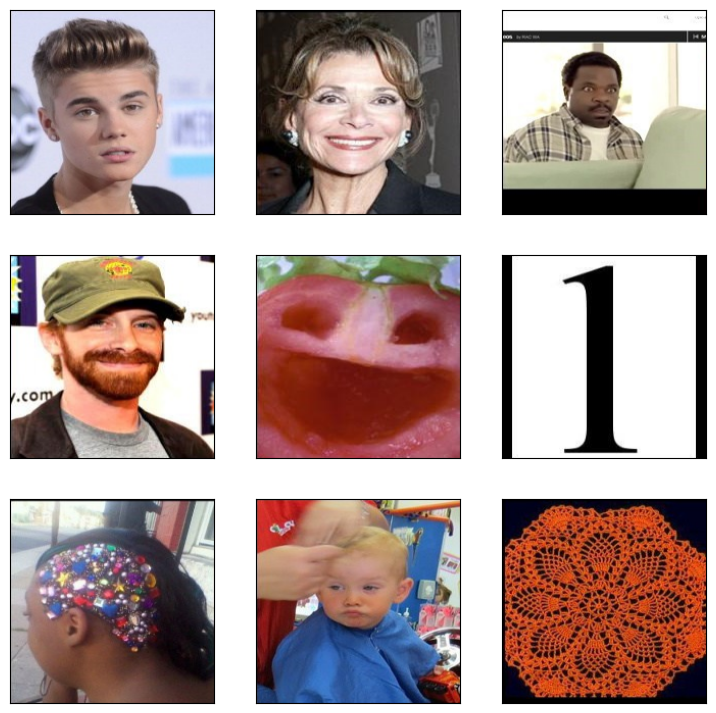

In [32]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""
    def show(ax, image_tensor):
        # Define a transform to convert a tensor to PIL image
        transform = transforms.ToPILImage()
        # Convert the tensor to PIL image using the above transform
        img = transform(image_tensor)

        ax.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig, axs = plt.subplots(3, 3, figsize=(9, 9))

    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(anchor, positive, negative)


## Pretrained ResNet model for embedding

In [33]:
import torch
import torch.nn.functional as F
import pandas as pd
import random
import numpy as np
from torchvision.models import resnet50
import torch.nn as nn

# Set random seeds for reproducibility
seed = 4234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

def compute_similarity(model, anchor, positive, negative):
    with torch.no_grad():
        anchor_embedding = model(anchor).squeeze(0).view(-1)
        positive_embedding = model(positive).squeeze(0).view(-1)
        negative_embedding = model(negative).squeeze(0).view(-1)

    positive_similarity = F.cosine_similarity(anchor_embedding.unsqueeze(0), positive_embedding.unsqueeze(0))
    negative_similarity = F.cosine_similarity(anchor_embedding.unsqueeze(0), negative_embedding.unsqueeze(0))

    return positive_similarity.item(), negative_similarity.item()

def run_inference_save_results(model, device, anchor, positive, negative, is_pretrained=True, csv_file_path="results_01.csv"):
    anchor = anchor.to(device, dtype=torch.float)
    positive = positive.to(device, dtype=torch.float)
    negative = negative.to(device, dtype=torch.float)

    model = model.to(device)
    model.eval()  # Set the model to evaluation mode

    pos_sim, neg_sim = compute_similarity(model, anchor, positive, negative)

    model_type = "Pretrained Model" if is_pretrained else "Fine-tuned Model"

    print(f"\nFor {model_type}:")
    print("Positive similarity:", pos_sim)
    print("Negative similarity:", neg_sim)

    # Save results to a CSV file
    data = {"Model Type": [model_type], "Positive Similarity": [pos_sim], "Negative Similarity": [neg_sim]}
    df = pd.DataFrame(data)
    df.to_csv(csv_file_path, index=False)

# Load a pre-trained ResNet model
resnet_model = resnet50()
embedding_resnet = nn.Sequential(*list(resnet_model.children())[:-1])


run_inference_save_results(embedding_resnet, device, anchor, positive, negative, is_pretrained=True, csv_file_path="results_02.csv")



For Pretrained Model:
Positive similarity: 0.9442646503448486
Negative similarity: 0.9614361524581909


In [34]:
# Set random seeds for reproducibility
seed = 4233
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

resnet_model = resnet50()
embedding_resnet = nn.Sequential(*list(resnet_model.children())[:-1])
run_inference_save_results(embedding_resnet, device, anchor, positive, negative, is_pretrained=True, csv_file_path="results_03.csv")


For Pretrained Model:
Positive similarity: 0.9428552389144897
Negative similarity: 0.9610273838043213


## Load fine-tuned Siamese model

In [35]:
fine_tuned_model = torch.load("epoch_10_model.pth")
embedding_finetuned = fine_tuned_model.embedding_net
run_inference_save_results(embedding_finetuned, device, anchor, positive, negative, is_pretrained=False, csv_file_path="results_04.csv")


For Fine-tuned Model:
Positive similarity: 0.9998197555541992
Negative similarity: 0.9997023344039917
